## **Spatio-Temporal Beam-Level Traffic Forecasting Challenge by ITU**
The objective of this challenge is to develop a multivariate time series forecasting model for traffic volume (DLThpVol) at the beam level.
* 2880 beams across 30 base stations
* each base station consists of 3 cells with 32 beams , with data recorded hourly
* dataset encompasses a five week period with data recorded at hourly intervals

* datasets:
    * traffic_DLThpVol.csv: represents throughput volume.
    * traffic_DLThpTime.csv: represents throughput time.
    * traffic_ DLPRB.csv: represents Physical Resource Block (PRB) utilization.
    * traffic_MR_number.csv: represents user count.

### **Notebook Objective**
* Lightgbm Modelling with the feature engineered data in the previous stage
* This

### **Note**
* This notebook requires **high ram** due to the large datasets and takes over 8hrs to train and requires a **GPU** and therefore it requires google colab pro with high memory/ It takes nearly 4 hours to run


#### Installing lightgbm with GPU support
* Please after running this block of cell restart the session

In [ ]:
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd

* Restart the session to use the newly installed lightgbm with gpu support

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import random
import pandas as pd
import numpy as np
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold
from sklearn.metrics import mean_absolute_error

import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
import torch


import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 500
pd.options.display.max_rows = 600

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)
 #cpu vars
    torch.manual_seed(seed_value)
# cpu  vars
    random.seed(seed_value)
 # Python
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
# gpu vars
        torch.backends.cudnn.deterministic = True
 #needed
        torch.backends.cudnn.benchmark = False
#Remember to use num_workers=0 when creating the DataBunch.

random_seed(42,True)

### **Data Loading**

In [ ]:
path = '/content/gdrive/MyDrive/spatio_temporal/prepared_data/'

In [ ]:
encoded_train_df = pd.read_parquet(path + 'encoded_train_final.parquet').drop(columns = [] )
encoded_test_df = pd.read_parquet(path + 'encoded_test_final.parquet').drop(columns = [])

In [ ]:
def convert_types(df):
    # Convert data types to reduce memory
    for c in df:
        col_type = str(df[c].dtypes)
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

        # Convert objects to category
        if col_type == 'object':
            df[c] = df[c].astype('category')

        # numerics
        elif col_type in numerics:
            c_min = df[c].min()
            c_max = df[c].max()
            if col_type[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[c] = df[c].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[c] = df[c].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[c] = df[c].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[c] = df[c].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[c] = df[c].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[c] = df[c].astype(np.float32)
                else:
                    df[c] = df[c].astype(np.float64)

    return df
encoded_train_df = convert_types(encoded_train_df)
encoded_test_df = convert_types(encoded_test_df)

### **Feature Selection and Modelling**

In [ ]:
def sqrt_transform(y):
    return np.sqrt(y)

def inverse_sqrt_transform(y):
    return np.square(y)
selected_columns_p =  ['daily_hr', 'hr', 'base_station', 'cell_type', 'beam',

                     'expanding_base_station_beam_cell_type_Target_shift_168_mean',
                    'expanding_base_station_beam_cell_type_Target_shift_336_mean',
                     'expanding_base_station_beam_cell_type_Target_shift_504_mean',

                     'expanding_base_station_beam_cell_type_prb_shift_168_mean',
                    'expanding_base_station_beam_cell_type_prb_shift_336_mean',
                    'expanding_base_station_beam_cell_type_prb_shift_504_mean',

                     'expanding_base_station_beam_cell_type_mrno_shift_168_mean',
                    'expanding_base_station_beam_cell_type_mrno_shift_336_mean',
                    'expanding_base_station_beam_cell_type_mrno_shift_504_mean',


                    'expanding_base_station_beam_cell_type_time_shift_168_mean',
                    'expanding_base_station_beam_cell_type_time_shift_336_mean',
                    'expanding_base_station_beam_cell_type_time_shift_504_mean',

                    ]+ [col for col in encoded_train_df.columns if 'previous' in col] + [col for col in encoded_train_df.columns if 'shifted' in col]

# drop_cols = [col for col in selected_columns_p if '_7'  in col]
drop_cols = []
# print(drop_cols)
selected_columns = [col for col in selected_columns_p if col not in drop_cols]
n_splits = encoded_train_df['fold'].nunique()
target_col = 'Target'
target_cols = ['Target','mrno', 'prb']
group_cols_list = [
    ['base_station'],
    ['hr'],
    ['daily_hr'],
    ['beam'],

    ['base_station', 'beam'],
    ['base_station', 'hr'],
    ['base_station', 'daily_hr'],
    ['base_station', 'cell_type'],
    ['base_station', 'cell_type', 'daily_hr'],
    ['base_station', 'cell_type', 'beam' ],
    ['base_station', 'cell_type', 'beam',  'daily_hr'],
    ['base_station', 'cell_type','beam',  'day'],
    ['base_station', 'beam', 'daily_hr'],


    ['beam', 'daily_hr'],
    ['beam', 'cell_type'],
    ['beam', 'cell_type', 'daily_hr'],

]
stats_to_use = ['mean', 'std', 'skew', 'min', 'max', '25th_percentile', '75th_percentile','95th_percentile']
# Initializing the OOF and fold predictions for both approaches
oof_preds_1 = np.zeros(len(encoded_train_df))
oof_preds_2 = np.zeros(len(encoded_train_df))
fold_pred_1 = []
fold_pred_2 = []

mae_approach_1 = []
mae_approach_2 = []


### **Modelling**
This code trains two LightGBM models using different feature subsets for **time-series regression** with **cross-validation**. The task involves two approaches to handle short-term and long-term predictions.

#### **Key Elements:**
1. **LightGBM Models**:
   - **Approach 1**: `lgb_params_2_approach_1` (with 1,000 estimators).
   - **Approach 2**: `lgb_params_2_approach_2` (with 5,000 estimators).
   - Both models use **MAE** as the objective and include GPU acceleration (`device='gpu'`).

2. **Target Transformation**:
   - Square root transformation is applied to the target variable for both training and predictions to stabilize variance.

3. **Feature Selection**:
   - **Approach 1**: Excludes lagged, expanding, and rolling features.
   - **Approach 2**: Includes all available features, including lag and expanding.

4. **Model Training & Validation**:
   - For each fold, two models are trained:
     - **Model 1** (Approach 1) on a subset of features for week 11
     - **Model 2** (Approach 2) on the full feature set for week 6
   - Predictions are made using the best iteration for each model, followed by an inverse square root transformation.

5. **Performance Evaluation**:
   - **MAE** is calculated for both approaches per fold, and **OOF (Out-Of-Fold)** predictions are stored.
   - Average MAE across all folds is computed for both approaches.

6. **Test Predictions**:
   - **Week 6** (immediate prediction): Uses Approach 2 (lag/expanding features).
   - **Week 11** (5-week gap): Uses Approach 1 (excludes lag/expanding features due to data becoming stale).

#### **Concept of Feature Subset Usage:**
- **Week 6**: Lagged, rolling, and expanding features are useful due to proximity to the training period.
- **Week 11**: Lagged/expanding features are excluded since the large gap (5 weeks) diminishes their relevance, avoiding stale data.

#### **Why This Strategy Is Effective:**
- **Short-term predictions** (like Week 6) benefit from incorporating recent data (lag, rolling, expanding) since recent trends are still impactful.
- **Long-term predictions** (like Week 11) should avoid relying on older data, which may no longer reflect the current state of the system. By excluding these features, the model avoids introducing irrelevant or outdated information.


In [ ]:
lgb_params = {'learning_rate': 0.06107031734204767, 'num_leaves': 151, 'max_depth': 8, 'feature_fraction': 0.7385191124705888, 'bagging_fraction': 0.998648903775685, 'bagging_freq': 8, 'min_child_samples': 10, 'lambda_l1': 1.011561569386919e-08, 'lambda_l2': 1.2665653189223212e-08, 'objective': 'mae'}
lgb_params_2_approach_1 = {'learning_rate': 0.02053584056236377, 'num_leaves': 254, 'max_depth': 10, 'feature_fraction': 0.6696720940035359, 'bagging_fraction': 0.7228804381516678, 'bagging_freq': 8, 'min_child_samples': 100, 'lambda_l1': 2.4850576136378315e-06, 'lambda_l2': 1.694355465523766e-08, 'n_estimators': 1000}
lgb_params_2_approach_2 = {'learning_rate': 0.08304613332693336, 'num_leaves': 151, 'max_depth': 9, 'feature_fraction': 0.7095128621678289, 'bagging_fraction': 0.9361601754529758, 'bagging_freq': 1, 'min_child_samples': 22, 'lambda_l1': 6.421772454121583e-07, 'lambda_l2': 0.0034348407467305964, 'n_estimators': 5000}
for fold in range(n_splits):
    print(f"Processing fold {fold+1}/{n_splits}")
    training = encoded_train_df[encoded_train_df['fold'] != fold]
    validation = encoded_train_df[encoded_train_df['fold'] == fold]

    # Apply sqrt transformation to the target
    y_train = sqrt_transform(training[target_col])
    y_test = sqrt_transform(validation[target_col])

    encoded_columns = [f"{target_col}_{'_'.join(cols)}_{stat}_te"
                       for target_col in target_cols
                       for cols in group_cols_list
                       for stat in stats_to_use]

    columns_approach_one = [col for col in selected_columns if 'shifted' not in col and 'previous' not in col and 'expanding' not in col]
    columns_approach_two = selected_columns
    print(columns_approach_one)
    print(columns_approach_two)

    X_train_1 = training[columns_approach_one + [col for col in encoded_columns if 'percentile' not in col]]
    X_test_1 = validation[columns_approach_one + [col for col in encoded_columns if 'percentile' not in col]]

    X_train_2 = training[columns_approach_two + encoded_columns]
    X_test_2 = validation[columns_approach_two + encoded_columns]

    # Train model for Approach 1
    model_1 = lgb.LGBMRegressor(**lgb_params_2_approach_1,
                                metric ='mae',
                                boosting_type= 'gbdt',
                                verbosity = -1,
                                num_bins = 63,
                                device =  'gpu',
                                n_jobs = -1,
                                objective = 'mae',
                               )
    model_1.fit(X_train_1, y_train, eval_set=(X_test_1, y_test))

    # Train model for Approach 2
    model_2 = lgb.LGBMRegressor(**lgb_params_2_approach_2,
                                metric ='mae',
                                boosting_type = 'gbdt',
                                verbosity = -1,
                                num_bins = 63,
                                device =  'gpu',
                                n_jobs = -1,
                                objective = 'mae',
                               )
    model_2.fit(X_train_2, y_train, eval_set=(X_test_2, y_test))

    # Make predictions for both approaches
    preds_1 = inverse_sqrt_transform(model_1.predict(X_test_1, model_1.best_iteration_))
    preds_2 = inverse_sqrt_transform(model_2.predict(X_test_2, model_2.best_iteration_))
    y_test_original = inverse_sqrt_transform(y_test)

    # Store OOF predictions
    oof_preds_1[validation.index] = preds_1
    oof_preds_2[validation.index] = preds_2

    # Calculate MAE for both approaches
    mae_1 = mean_absolute_error(y_test_original, preds_1)
    mae_2 = mean_absolute_error(y_test_original, preds_2)
    print(f"MAE for Approach 1, Fold {fold}: {mae_1}")
    print(f"MAE for Approach 2, Fold {fold}: {mae_2}")
    print("-"* 100)

    mae_approach_1.append(mae_1)
    mae_approach_2.append(mae_2)



    preds_test_1 = inverse_sqrt_transform(model_1.predict(encoded_test_df[encoded_test_df['week'] == 11][columns_approach_one +  [col for col in encoded_columns if 'percentile' not in col]], model_1.best_iteration_))
    preds_test_2 = inverse_sqrt_transform(model_2.predict(encoded_test_df[encoded_test_df['week'] == 6][columns_approach_two + encoded_columns], model_2.best_iteration_))

    fold_pred_1.append(preds_test_1)
    fold_pred_2.append(preds_test_2)

# Print overall MAE for both approaches
print(f"Average MAE for Approach 1: {np.mean(mae_approach_1)}")
print(f"Average MAE for Approach 2: {np.mean(mae_approach_2)}")

# # Add OOF predictions to the original train DataFrame
encoded_train_df['oof_preds_1'] = oof_preds_1
encoded_train_df['oof_preds_2'] = oof_preds_2


Processing fold 1/10
['daily_hr', 'hr', 'base_station', 'cell_type', 'beam']
['daily_hr', 'hr', 'base_station', 'cell_type', 'beam', 'expanding_base_station_beam_cell_type_Target_shift_168_mean', 'expanding_base_station_beam_cell_type_Target_shift_336_mean', 'expanding_base_station_beam_cell_type_Target_shift_504_mean', 'expanding_base_station_beam_cell_type_prb_shift_168_mean', 'expanding_base_station_beam_cell_type_prb_shift_336_mean', 'expanding_base_station_beam_cell_type_prb_shift_504_mean', 'expanding_base_station_beam_cell_type_mrno_shift_168_mean', 'expanding_base_station_beam_cell_type_mrno_shift_336_mean', 'expanding_base_station_beam_cell_type_mrno_shift_504_mean', 'expanding_base_station_beam_cell_type_time_shift_168_mean', 'expanding_base_station_beam_cell_type_time_shift_336_mean', 'expanding_base_station_beam_cell_type_time_shift_504_mean', 'rolling_previous_Target_mean_336', 'rolling_previous_Target_median_336', 'rolling_previous_Target_std_336', 'rolling_previous_Targe

### **Feature Importance**

Text(0.5, 1.0, 'CatBoostClassifier features importance (top 50):')

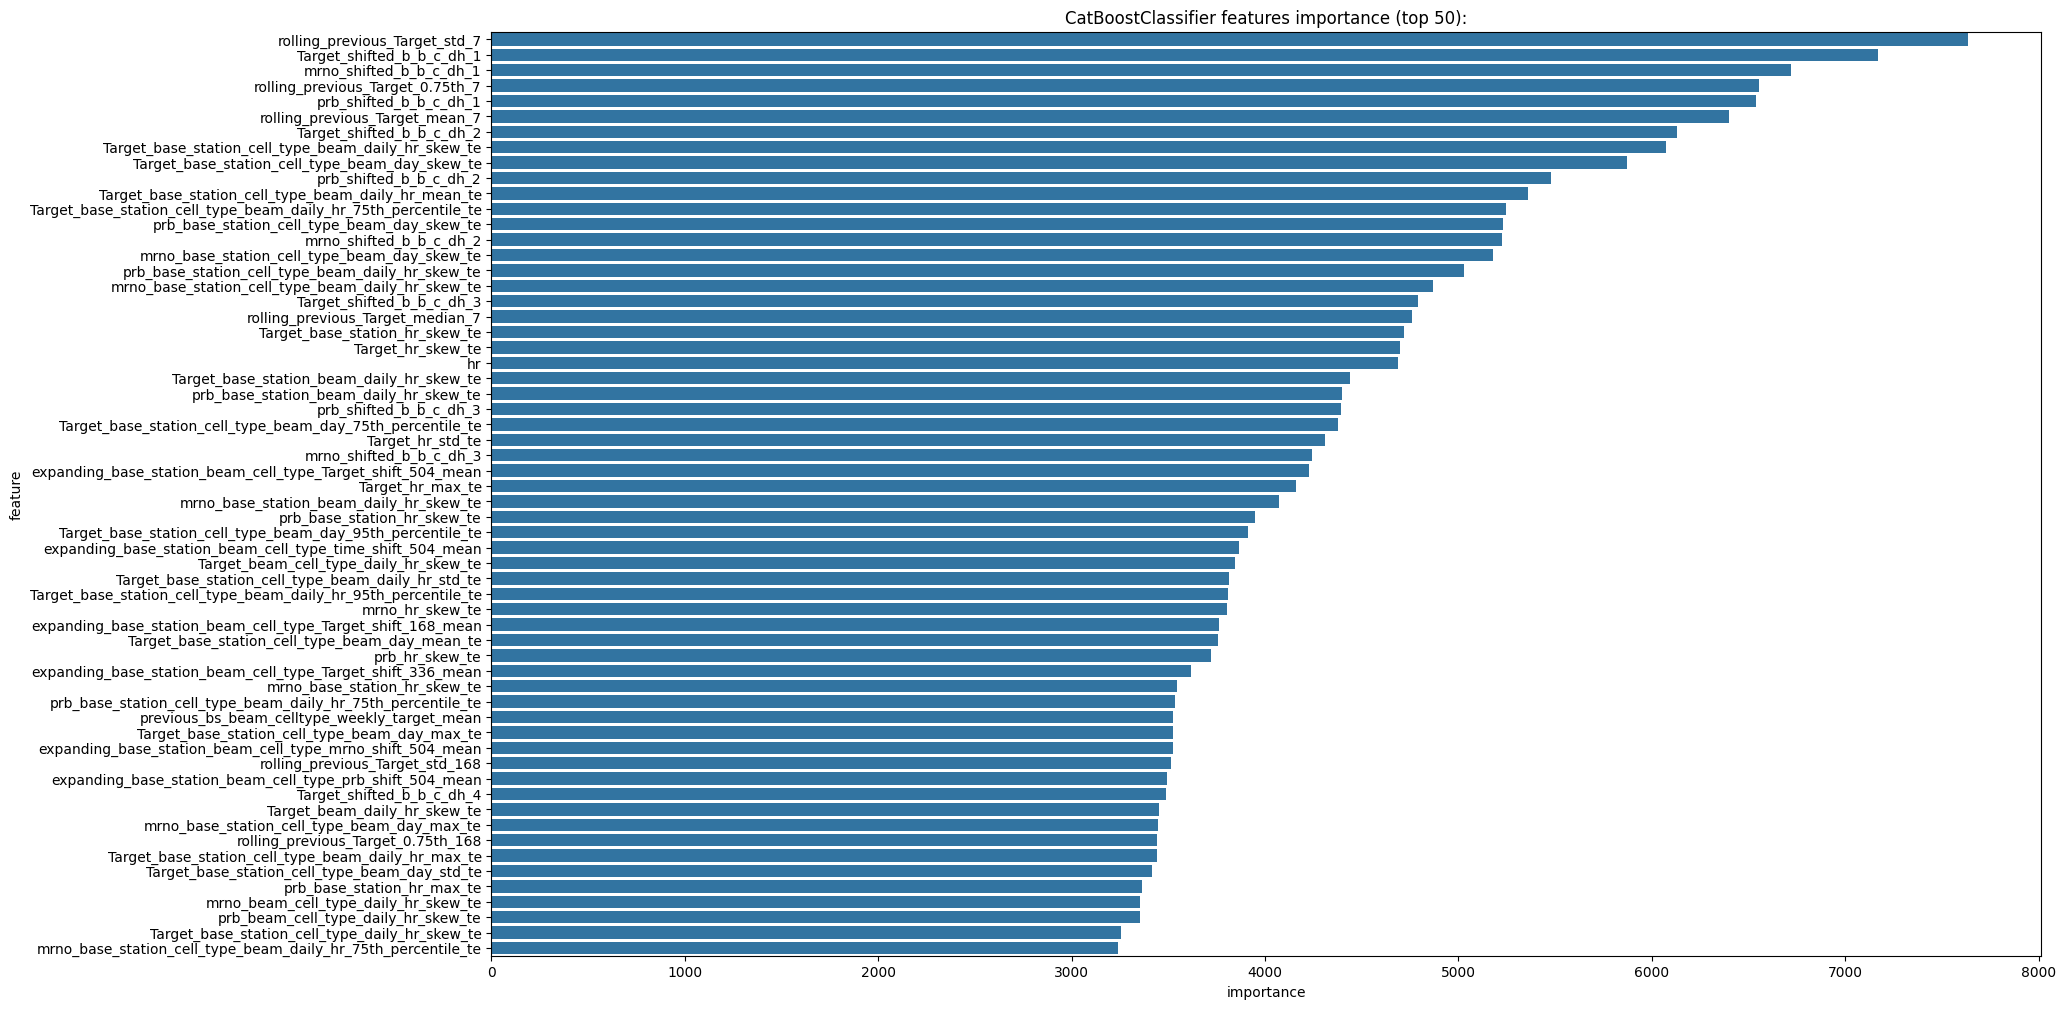

In [ ]:
feature_importance_df = pd.DataFrame(model_2.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = columns_approach_two + encoded_columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('CatBoostClassifier features importance (top 50):')

### **Submission**


In [1]:
# Predict for week 11 using Approach 1
week_11_preds = np.mean([pred for pred in fold_pred_1], axis=0)
week_11_test = encoded_test_df[encoded_test_df['week'] == 11].copy()
week_11_test['preds'] = week_11_preds

# Predict for week 6 using Approach 2
week_6_preds = np.mean([pred for pred in fold_pred_2], axis=0)
week_6_test = encoded_test_df[encoded_test_df['week'] == 6].copy()
week_6_test['preds'] = week_6_preds

# Concatenate the predictions
final_submission = pd.concat([week_11_test[['ID', 'preds']], week_6_test[['ID', 'preds']]])

# Optionally, save the submission to a CSV file
final_submission.to_csv(path + 'submission_lgb_5000_upd.csv', index=False)

# Preview the submission
display(final_submission.head())
